# Identifying Entities in Healthcare Data

## 1. Introduction


A health tech company called **‘BeHealthy’**. They aim to connect the medical communities with millions of patients across the country.
BeHealthy has a web platform that allows doctors to list their services and manage patient interactions and provides services for patients such as booking interactions with doctors and ordering medicines online. Here, doctors can easily organise appointments, track past medical records and provide e-prescriptions.

### Problem Statement

**BeHealthy** require <font color = 'aqua'>**predictive model**</font> which can <font color = 'lightgreen'>**identify disease and treatment**</font> from the patients interaction with doctor or ordering medicines online

### Approach

- By observing the requirement, it is clearly visible that we have to process the textual sentence and identify the entities like **Disease and Treatment**. We can predict these all requirements using
        -  CRF (Conditional Random Field) classifier
        -  Random Forest Classifier
        -  HMM (Hidden Markov Model)

#### Model Explanation
1. For Medical Entity Recognition, we are building CRF model which uses custom NER becuase the entities we are planning to recognise all are related to medical terminologies.
2. Luckily!! we received dataset which contains sentences along with labels, labels/tags are very important for Entity recognition. *If your dataset is not labelled, you have to manually label the data for Model Building and Prediction*.

#### Dataset Explanation
We have four data file for this activity to proceed, they are
1. Train Sentence Dataset
2. Train Label Dataset
3. Test Sentence Dataset
4. Test Label Dataset

Sentence file contains all interations between patients and doctor and Label file contains all enitiy tags for particular words arranged as per sentence. We need to do few preprocessing while accessing dataset we will explore that in further steps

#### Library Explanation
1. Pandas - Dataframe, Content storage and processing
2. Regular Expression (re) - Identify the textual pattern
3. SpaCy - NLP, POS tag check
4. Warnings - To avoid warning messages
5. Sklearn_CRFsuite - Model building and Evaluation

#### Workspace set up: Import and Install useful packages.

In [60]:
# !pip install pycrf
# !pip install sklearn-crfsuite
# !pip install spacy

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import pandas as pd

# Import model and metrics
from sklearn_crfsuite import CRF, scorers, metrics
model = spacy.load("en_core_web_sm")

## 2. Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

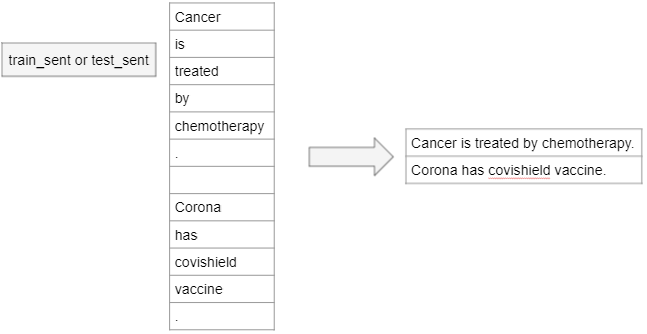

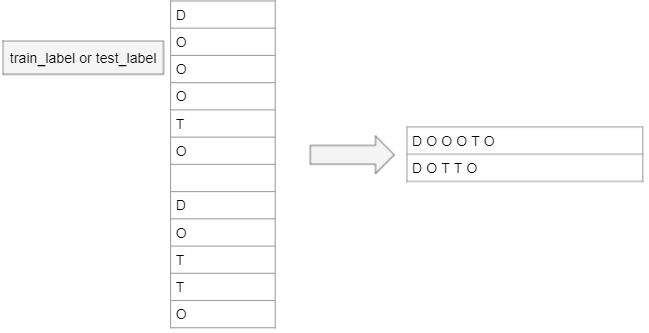

In [9]:
train_sent = "/home/sreehari-wipro/Study/study_venv/NLP/Assignment/train_sent"
train_label = "/home/sreehari-wipro/Study/study_venv/NLP/Assignment/train_label"
test_sent = "/home/sreehari-wipro/Study/study_venv/NLP/Assignment/test_sent"
test_label = "/home/sreehari-wipro/Study/study_venv/NLP/Assignment/test_label"

In [1]:
def read_sentences_and_labels(sent_file, label_file):
    sentences = []
    labels = []
    
    with open(sent_file, 'r') as sf, open(label_file, 'r') as lf:
        sentence = []
        label = []
        
        for word, lbl in zip(sf, lf):
            word = word.strip()
            lbl = lbl.strip()
            
            if word and lbl:
                sentence.append(word)
                label.append(lbl)
            else:
                if sentence and label:
                    sentences.append(sentence)
                    labels.append(label)
                    sentence = []
                    label = []
                    
        if sentence and label:
            sentences.append(sentence)
            labels.append(label)
            
    return sentences, labels

In [2]:
def print_first_n_sentences(sentences, labels, n=5):
    for i in range(min(n, len(sentences))):
        print("Sentence {}:".format(i+1))
        print("Words: " + ' '.join(sentences[i]))
        print("Labels: " + ' '.join(labels[i]))
        print()

In [6]:
# Read sentences and labels
train_sentences, train_labels = read_sentences_and_labels(train_sent, train_label)

In [10]:
test_sentences, test_labels = read_sentences_and_labels(test_sent, test_label)

In [7]:
# Print the first 5 sentences
print_first_n_sentences(train_sentences, train_labels, n=5)

Sentence 1:
Words: All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Labels: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

Sentence 2:
Words: The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Labels: O O O O O O O O O O O O O O O O O O O O O O O O O

Sentence 3:
Words: Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
Labels: O O O O O O O O O O O O O O O

Sentence 4:
Words: The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Labels: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

Sentence 5:
Words: Arrest of dilation was the

### Count the number of sentences in the processed train and test dataset 

In [11]:
print ("number of sentences in train data: ", len(train_sentences))
print ("\nnumber of sentences in test data: ", len(test_sentences)) 

number of sentences in train data:  2599

number of sentences in test data:  1056


### Count the number of lines of labels in the processed train and test dataset.

In [12]:
print ("number of labels in train data: ", len(train_labels))
print ("\nnumber of labels in test data: ", len(test_labels))

number of labels in train data:  2599

number of labels in test data:  1056


## 3. Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [13]:
from collections import Counter
def extract_nouns_and_proper_nouns(sentences):
    noun_freq = Counter()
    
    for sentence in sentences:
        doc = model(' '.join(sentence))
        for token in doc:
            if token.pos_ in ['NOUN', 'PROPN']:
                noun_freq[token.text] = noun_freq.get(token.text, 0) + 1
    
    return noun_freq

In [14]:
noun_freq = extract_nouns_and_proper_nouns(train_sentences)
# Print the noun frequencies
print("Noun Frequencies:")
for noun, freq in noun_freq.items():
    print(f"{noun}: {freq}")

Noun Frequencies:
births: 1
weeks: 27
University: 6
Vermont: 1
delivery: 18
route: 2
indication: 3
age: 34
parity: 1
practice: 22
group: 63
risk: 49
status: 14
rate: 46
%: 161
presentation: 6
medicine: 29
patients: 354
Arrest: 1
dilation: 1
subgroups: 1
rates: 22
care: 47
hospitals: 8
community: 11
groups: 23
trimester: 4
fluid: 5
index: 11
AFI: 5
temperature: 5
increases: 6
decrease: 3
June: 2
August: 5
period: 22
heat: 2
women: 48
singleton: 1
pregnancies: 7
gestation: 4
testing: 15
determinations: 2
ambient: 1
area: 8
day: 27
mean: 1
test: 15
date: 2
Spearman: 1
rank: 1
Correlation: 3
relationship: 9
account: 4
measure: 3
well: 2
being: 2
study: 103
population: 23
diabetes: 23
screening: 10
clinic: 4
Hadassah: 1
Medical: 5
Center: 3
year: 27
treatment: 195
week: 6
protocol: 5
control: 30
characteristics: 14
differences: 13
mode: 3
Apgar: 1
scores: 4
infants: 17
cases: 46
aim: 7
contribution: 3
markers: 18
diagnosis: 40
fetuses: 6
years: 45
syndrome: 45
Edward: 2
trisomies: 1
Patau: 

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [15]:
# Print the top 25 most common nouns and proper nouns
print("Top 25 Most Common Nouns and Proper Nouns:")
for noun, freq in noun_freq.most_common(25):
    print(f"{noun}: {freq}")

Top 25 Most Common Nouns and Proper Nouns:
patients: 354
treatment: 195
%: 161
cancer: 135
therapy: 120
disease: 105
study: 103
cell: 99
lung: 87
chemotherapy: 65
group: 63
effects: 61
gene: 54
results: 54
TO_SEE: 54
use: 53
surgery: 51
survival: 50
risk: 49
women: 48
care: 47
analysis: 47
children: 47
activity: 47
rate: 46


## 4. Defining features for CRF






#### This Python function, `word2features`, is designed to create feature sets for each word in a sentence.

**Parameters:**
    sent (list): A list of tuples, where each tuple represents a word and its Part-of-Speech (POS) tag.
    i (int): The index of the current word in the sentence.

**Returns:**
    dict: A dictionary representing the features for the word at index `i` in the sentence.

**Steps:**
1. Current Word Features:
    - The function creates a dictionary named `features` to store the features.
    - It starts with a 'bias' feature always set to 1.0 (common practice in machine learning).
    - It extracts various features from the current word (`word`) and its POS tag (`postag`):
        - Lowercased word (`word.lower()`)
        - First letter (`word[0]`)
        - Last letter (`word[-1]`)
        - Last two characters (`word[-2:]`)
        - Check if the word is uppercase (`word.isupper()`)
        - Check if the word is title case (`word.istitle()`)
        - Check if the word is a digit (`word.isdigit()`)
        - The POS tag itself (`postag`)
        - Check if the POS tag is a noun or pronoun (`postag_isnounpronoun`) (created using set membership)
        - Prefix of the POS tag (`postag[:2]`)

2. Previous Word Features (if available):
    - If `i` is not the first word (`i > 0`), it extracts features from the previous word (`word1`) and its POS tag (`postag1`) using similar checks as for the current word.
    - These features have a prefix of `-1:` to indicate they are related to the previous word.
    - A special feature `BOS` (Beginning Of Sentence) is added if it's the first word (`else` block).

3. Next Word Features (if available):
    - Similar to the previous word, if `i` is not the last word (`i < len(sent)-1`), it extracts features from the next word (`word1`) and its POS tag (`postag1`).
    - These features have a prefix of `+1:` to indicate they are related to the next word.
    - A special feature `EOS` (End Of Sentence) is added if it's the last word (`else` block).

Returns:
    dict: The final dictionary `features` contains all the extracted features for the current word, considering its own properties, the previous word (if available), and the next word (if available).





In [53]:
# Let's define the features to get the feature value for one word.
# Feature set
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    # features for the current word
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[0]': word[0],
        'word[-1]': word[-1],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag':postag,
        'postag_isnounpronoun': postag in ['NOUN','PROPN'],
        'postag[:2]': postag[:2],
    }
    # features for the previous word
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word[0]': word1[0],
            '-1:word[-1]': word1[-1],
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
            '-1:postag_isnounpronoun': postag1 in ['NOUN','PROPN']
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
            '+1:postag_isnounpronoun': postag1 in ['NOUN','PROPN']
        })
    else:
        features['EOS'] = True

    return features


### Getting the features

#### Function to get the features for a sentence

In [54]:
# Write a code to get features for a sentence.
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

#### Function to get the labels of a sentence

In [55]:
# Write a code to get the labels for a sentence.
def sent2labels(sent):
    return [label for token, postag, label in sent]

## 5. EDA

### Extract POS information using SpaCy

In [20]:
# Dataframe of POS tagging,Lemma word and Label for Train and test sentence
train_df = pd.DataFrame(columns=['sentence','word','lemma','pos','label'])
test_df = pd.DataFrame(columns=['sentence','word','lemma','pos','label'])

In [33]:
#Formatiiing the train and test data
def format(nested_list):
    flattened_list = [' '.join(sentence) for sentence in nested_list]
    return flattened_list

In [38]:
train_sent = format(train_sentences)
train_label = format(train_labels)
test_sent = format(test_sentences)
test_label = format(test_labels)

In [40]:
#train datframe

i=0 #Sentence count
j=0 #Iteration count

for sent,label in zip(train_sent,train_label):
    i+=1
    for s,l in zip(sent.split(),label.split()):
        doc = model(s)
        for tok in doc:
            train_df.loc[j,['sentence','word','lemma','pos','label']] = [i,tok.text,tok.lemma_,tok.pos_,l]
            j+=1

In [42]:
#test datframe

i=0 #Sentence count
j=0 #Iteration count

for sent,label in zip(test_sent,test_label):
    i+=1
    for s,l in zip(sent.split(),label.split()):
        doc = model(s)
        for tok in doc:
            test_df.loc[j,['sentence','word','lemma','pos','label']] = [i,tok.text,tok.lemma_,tok.pos_,l]
            j+=1

#### Frequence of words for POS tag as NOUN & PROPN for combined dataset (train & test)

In [43]:
# Word and it's frequency for word which contains NOUN or PROPN as POS tagging
freq_df = pd.DataFrame()
freq_df = pd.concat((train_df,test_df),axis=0)

# Resetting index
freq_df.reset_index(inplace=True,drop=True)

# Top 25 most frequency values for Train and Test related dataset words
freq_df[(freq_df['pos'] == 'NOUN') | ((freq_df['pos'] == 'PROPN'))]['word'].value_counts()[:25]

word
patients        492
treatment       281
cancer          200
therapy         175
disease         143
cell            140
lung            116
group            94
gene             88
chemotherapy     88
effects          85
results          79
women            77
patient          75
TO_SEE           75
surgery          71
risk             71
cases            71
analysis         70
human            67
rate             67
response         66
survival         65
children         64
effect           64
Name: count, dtype: int64

In [44]:
# Top 25 most frequency values for Train and Test related lemma words
freq_df[(freq_df['pos'] == 'NOUN') | ((freq_df['pos'] == 'PROPN'))]['lemma'].value_counts()[:25]

lemma
patient         587
treatment       316
cancer          226
cell            203
therapy         182
disease         172
effect          163
case            132
group           128
lung            120
result          118
gene            112
year            105
rate            102
trial            91
chemotherapy     91
woman            89
analysis         86
protein          82
response         81
risk             78
child            78
human            77
TO_SEE           75
mutation         75
Name: count, dtype: int64

### Dataframe (Sentence, word, POS) visualisation

In [45]:
train_df.head(5)

,sentence,word,lemma,pos,label
0,1,All,all,PRON,O
1,1,live,live,VERB,O
2,1,births,birth,NOUN,O
3,1,>,>,PUNCT,O
4,1,or,or,CCONJ,O


In [46]:
test_df.head(5)

,sentence,word,lemma,pos,label
0,1,Furthermore,furthermore,ADV,O
1,1,",",",",PUNCT,O
2,1,when,when,SCONJ,O
3,1,all,all,PRON,O
4,1,deliveries,delivery,NOUN,O


### Sentense-wise detail dataframe preparation

The sentencedetail class is designed to process a dataframe containing word-level information and group it by sentences, extracting details like words, part-of-speech tags, and labels

In [48]:
# A class to retrieve the sentences details from the dataframe
class sentencedetail(object):
    def __init__(self, data):
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, l) for w, p, l in zip(s["word"].values.tolist(), s["pos"].values.tolist(),s["label"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [49]:
# Fetch detail view of sentence for train set
train_sent_obj = sentencedetail(train_df)
train_sent_detail = train_sent_obj.sentences

In [50]:
# Display one sentence detail view for train set
train_sent_detail[0]

[('All', 'PRON', 'O'),
 ('live', 'VERB', 'O'),
 ('births', 'NOUN', 'O'),
 ('>', 'PUNCT', 'O'),
 ('or', 'CCONJ', 'O'),
 ('=', 'VERB', 'O'),
 ('23', 'NUM', 'O'),
 ('weeks', 'NOUN', 'O'),
 ('at', 'ADP', 'O'),
 ('the', 'PRON', 'O'),
 ('University', 'NOUN', 'O'),
 ('of', 'ADP', 'O'),
 ('Vermont', 'PROPN', 'O'),
 ('in', 'ADP', 'O'),
 ('1995', 'NUM', 'O'),
 ('(', 'PUNCT', 'O'),
 ('n', 'CCONJ', 'O'),
 ('=', 'VERB', 'O'),
 ('2395', 'NUM', 'O'),
 (')', 'PUNCT', 'O'),
 ('were', 'AUX', 'O'),
 ('retrospectively', 'ADV', 'O'),
 ('analyzed', 'VERB', 'O'),
 ('for', 'ADP', 'O'),
 ('delivery', 'NOUN', 'O'),
 ('route', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('indication', 'NOUN', 'O'),
 ('for', 'ADP', 'O'),
 ('cesarean', 'VERB', 'O'),
 (',', 'PUNCT', 'O'),
 ('gestational', 'ADJ', 'O'),
 ('age', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('parity', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('and', 'CCONJ', 'O'),
 ('practice', 'VERB', 'O'),
 ('group', 'NOUN', 'O'),
 ('(', 'PUNCT', 'O'),
 ('to', 'PART', 'O'),
 ('reflect

In [51]:
# Fetch detail view of sentence for test set
test_sent_obj = sentencedetail(test_df)
test_sent_detail = test_sent_obj.sentences

# Display one sentence detail view for test set
test_sent_detail[0]

[('Furthermore', 'ADV', 'O'),
 (',', 'PUNCT', 'O'),
 ('when', 'SCONJ', 'O'),
 ('all', 'PRON', 'O'),
 ('deliveries', 'NOUN', 'O'),
 ('were', 'AUX', 'O'),
 ('analyzed', 'VERB', 'O'),
 (',', 'PUNCT', 'O'),
 ('regardless', 'ADV', 'O'),
 ('of', 'ADP', 'O'),
 ('risk', 'NOUN', 'O'),
 ('status', 'NOUN', 'O'),
 ('but', 'CCONJ', 'O'),
 ('limited', 'VERB', 'O'),
 ('to', 'PART', 'O'),
 ('gestational', 'ADJ', 'O'),
 ('age', 'NOUN', 'O'),
 ('>', 'PUNCT', 'O'),
 ('or', 'CCONJ', 'O'),
 ('=', 'VERB', 'O'),
 ('36', 'NUM', 'O'),
 ('weeks', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('the', 'PRON', 'O'),
 ('rates', 'NOUN', 'O'),
 ('did', 'VERB', 'O'),
 ('not', 'PART', 'O'),
 ('change', 'VERB', 'O'),
 ('(', 'PUNCT', 'O'),
 ('12.6', 'NUM', 'O'),
 ('%', 'INTJ', 'O'),
 (',', 'PUNCT', 'O'),
 ('280', 'NUM', 'O'),
 ('of', 'ADP', 'O'),
 ('2214', 'NUM', 'O'),
 (';', 'PUNCT', 'O'),
 ('primary', 'NOUN', 'O'),
 ('9.2', 'NUM', 'O'),
 ('%', 'INTJ', 'O'),
 (',', 'PUNCT', 'O'),
 ('183', 'NUM', 'O'),
 ('of', 'ADP', 'O'),
 ('199

## 6. Define input and target variables


1. Correctly computing X and Y sequence matrices for training and test data.Check that both sentences and labels are processed
2. Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 
3. Define the labels as the target variable for test and the train dataset

In [56]:
# Prepare X-train and X-test by extracting features from train and test dataset
X_train = [sent2features(s) for s in train_sent_detail]
X_test = [sent2features(s) for s in test_sent_detail]

In [58]:
# Prepare y-train and y-test by extracting labels from train and test dataset
y_train = [sent2labels(l) for l in train_sent_detail]
y_test = [sent2labels(l) for l in test_sent_detail]

## 7. Build the CRF Model

In [61]:
# CRF model using sklearn
crf = CRF(max_iterations=100, c1=1.0, c2=0.01, all_possible_transitions=False)

try:
# fit the model
  crf.fit(X_train, y_train)
except AttributeError:
   pass


## 8. Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [64]:
# Taken out predicted label from the model
pred_label=[]
for i in y_pred:
    pred_label.extend(i)

# Loaded into test dataframe
test_df['label_predicted'] = pred_label

# Visualise top 5 data
test_df.head(5)

,sentence,word,lemma,pos,label,label_predicted
0,1,Furthermore,furthermore,ADV,O,O
1,1,",",",",PUNCT,O,O
2,1,when,when,SCONJ,O,O
3,1,all,all,PRON,O,O
4,1,deliveries,delivery,NOUN,O,O


### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

#### F1 Score :


In [62]:
# Calculate the f1 score using the test data
y_pred = crf.predict(X_test)
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print('Predicted F1-score for Medical Entity Dataset is: {0} % '.format(round(f1_score*100,2)))

Predicted F1-score for Medical Entity Dataset is: 91.47 % 


* We got an F1 score of 0.97 which is a good score. This is a satisfactory score. We may further improve the model by tuning the hyperparameters.

### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

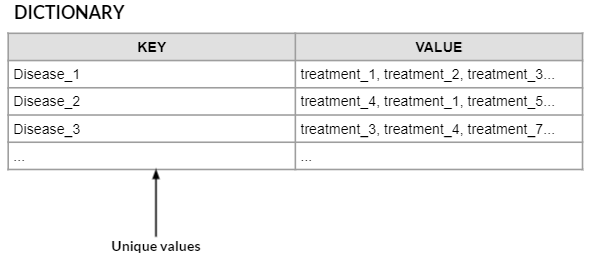

In [73]:
# Preparing dictionary by keeping Disease as unique Key element and Treatment as value element
new_df =test_df[(test_df['label_predicted'] != 'O')]
new_df.set_index('sentence',inplace=True)
disease=[]
treatment=[]
sentence=[]
med_dict = {}
for i in new_df.index.unique():
    try:
        val = new_df.loc[i,'label_predicted'].unique()
        if len(val) == 2:
            disease_val = new_df[new_df['label_predicted'] == 'D'].loc[i,'word']
            treatment_val = new_df[new_df['label_predicted'] == 'T'].loc[i,'word']
            disease_single = disease_val if type(disease_val) == str else " ".join(disease_val)
            treatment_single = treatment_val if type(treatment_val) == str else " ".join(treatment_val)
            if disease_single not in disease:
                med_dict[disease_single] = treatment_single
            else:
                print('Entered')
                med_dict[disease_single] = med_dict.get(disease_single)+'/'+treatment_single
    except AttributeError:
        pass

In [74]:
import pprint as pp
pp.pprint(med_dict, indent = 4)


{   "'s disease": 'Ovine Johne',
    'AOM': 'Amoxicillin remains the antibiotic of choice',
    'Alopecia': 'tacrolimus therapy',
    'B16 melanoma': 'adenosine triphosphate and treatment with buthionine '
                    'sulfoximine',
    "Eisenmenger 's syndrome": 'laparoscopic cholecystectomy',
    "Parkinson 's disease": 'Microelectrode - guided posteroventral '
                            'pallidotomy',
    'acoustic neuroma': 'Stereotactic radiosurgery',
    'acute cerebral ischemia': 'Antiplatelet therapy',
    'acute myocardial infarction': 'thrombolytic treatment',
    'acute nasopharyngitis': 'antibiotic treatment',
    'advanced non -- small - cell lung cancer': 'paclitaxel plus carboplatin ( '
                                                'pc ) vinorelbine plus '
                                                'cisplatin ( vc )',
    'advanced nsclc': 'assessing combination chemotherapy of cisplatin , '
                      'ifosfamide and irinotecan with rhg - csf 

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

#### Using Dictionary

In [75]:
def predict_treatment_for_disease(disease_name, med_dict):
    """
    Predicts the treatment for a given disease name using a medical dictionary.
    """
    # Initialize the treatment variable
    treatment = ''

    # Check if the disease name exists in the dictionary
    if disease_name in med_dict:
        treatment = med_dict[disease_name]
    else:
        treatment = 'None'

    return treatment

In [89]:

disease_name = 'retinoblastoma'

treatment = predict_treatment_for_disease(disease_name, med_dict)
print('Identified Disease:', disease_name)
print('Identified Treatment:', treatment)

Identified Disease: retinoblastoma
Identified Treatment: radiotherapy


#### Extract disease from a sentence and use model to predict treatment:

In [83]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm')

def predict_treatment(input_sent, crf_model, med_dict):
    """
    Predicts the treatment for a given input sentence using a CRF model and a medical dictionary.
    """
    d = []
    disease = ''
    test_sent = []
    treatment = ''

    # Process the input sentence with spaCy
    doc = nlp(input_sent)
    for token in doc:
        d.append((token.text, token.pos_, 'D'))  # Assuming all tokens are to be tagged with 'D' for demonstration

    # Convert the processed sentence into features suitable for CRF model prediction
    test_sent.append(sent2features(d))

    # Predict the labels using the CRF model
    predicted_labels = crf.predict(test_sent)[0]
    
    for i, tag in enumerate(predicted_labels):
        if tag == 'D':
            tr = input_sent.split()[i]
            disease += tr + ' '
            if tr in med_dict:
                treatment += ' ' + med_dict.get(tr)

    disease = disease.strip()
    treatment = treatment.strip()

    if not treatment:
        treatment = 'None'

    return disease, treatment




Identified Disease: cancer
Identified Treatment: Matrix metalloproteinase inhibitors


In [88]:
input_sent = 'What is the treatment for the condion hereditary retinoblastoma'

disease, treatment = predict_treatment(input_sent, crf, med_dict)
print('Identified Disease:', disease)
print('Identified Treatment:', treatment)

Identified Disease: retinoblastoma
Identified Treatment: radiotherapy


### End of Doc